## Main.ipynb
Main file for accumulating examples of breakout trades.
Goal is to use example trades to train a model on these metalabeled trades.

In [25]:
import mplfinance as mpf
import numpy as np
import pandas as pd
import yfinance as yf

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from neurotrader.trendline_automation import fit_upper_trendline, fit_lower_trendline
from neurotrader.trendline_break_dataset import trendline_breakout_dataset

DEFAULT_LOOKBACK = 168

In [26]:
def conf_matrix_to_df(conf_matrix):
    return pd.DataFrame(conf_matrix)

In [27]:
# Download stock data for a variety of tickers, blue chips for now
# Period params: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
# Interval params: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
aapl = yf.download('U', period='max', interval='1d')
aapl.drop('Adj Close', axis=1)

# TODO: For now, aapl will be the training data and msft will be test data. Adjust later.
msft = yf.download('MSFT', period='5y', interval='1d')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [28]:
# Run trendline_breakout_dataset and accumulate examples
aapl_trades, x_train, y_train = trendline_breakout_dataset(aapl, DEFAULT_LOOKBACK)
msft_trades, x_test, y_test = trendline_breakout_dataset(msft, DEFAULT_LOOKBACK)

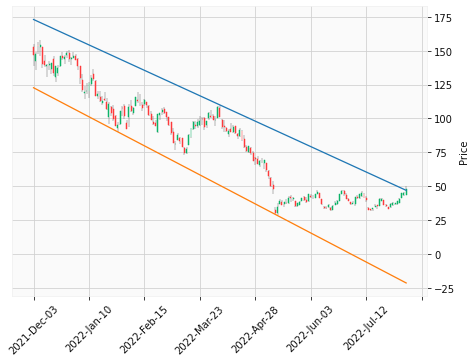

In [29]:
# Plot of example trade, its trendlines, and breakout candle.
index = int(aapl_trades.iloc[0].loc['entry_i'])
aapl_window = aapl[index-DEFAULT_LOOKBACK:index]  # +1 to include candle breaking out of resistance
aapl_window_display = aapl[index-DEFAULT_LOOKBACK:index+1]  # +1 to include candle breaking out of resistance

resist_coefs = fit_upper_trendline(aapl_window['High'])
support_coefs = fit_lower_trendline(aapl_window['Low'])
r_trendline_values = resist_coefs[0] * np.arange(len(aapl_window_display)) + resist_coefs[1]
s_trendline_values = support_coefs[0] * np.arange(len(aapl_window_display)) + support_coefs[1]

apds = [mpf.make_addplot(pd.DataFrame(r_trendline_values)),
        mpf.make_addplot(pd.DataFrame(s_trendline_values))]
mpf.plot(aapl_window_display, type='candle', style='yahoo', addplot=apds)

In [30]:
# Training a SVM on the metalabled data
model = SVC(kernel="linear")
model.fit(x_train, y_train)
results = model.predict(x_test)
print(results)

[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]


In [31]:
# Training a SVM on the metalabled data
# Confusion Matrix for analysis
print(conf_matrix_to_df(confusion_matrix(y_test, results)))

   0  1
0  8  0
1  8  1
